# Heatmap plots for dieases heritability

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

## Functions

In [38]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """
    
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labelsize=18,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-45, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


In [39]:
def plot_heatmap(df, group, size=(8,8), direction='ALL'):
    fig, ax = plt.subplots(figsize=size)
    plt.rcParams.update({'font.size': 18})
    im, cbar = heatmap(df, df.index, df.columns, 
                       ax=ax, cmap="YlGn", 
                       cbarlabel="-ln(Enrichment Pvalue)")
    texts = annotate_heatmap(im, valfmt="{x:.1f}")
    fig.tight_layout()
    plt.savefig('heatmap_disease_h2_%s_%s_DEG.png' % (group, direction))
    plt.savefig('heatmap_disease_h2_%s_%s_DEG.pdf' % (group, direction))
    plt.savefig('heatmap_disease_h2_%s_%s_DEG.svg' % (group, direction))
    plt.show()

## Generate heatmaps

In [4]:
sheet_names = ['All', 'DLPFC', 'Caudate', 'Hippo']

### All DEGs

In [16]:
df_all = pd.DataFrame()
for sheet in sheet_names:
    dfx = pd.read_excel("../_h/h2_summary.xlsx", sheet_name=sheet)\
            .loc[:, ['Trait', 'Type', 'Enrichment_p']]
    dfx['-Log10_p'] = -np.log(dfx.Enrichment_p)
    dfx['Tissue'] = sheet
    df_all = pd.concat([df_all, dfx], axis=0)

df = df_all.pivot_table(index=['Trait', 'Type'], 
                        columns='Tissue', 
                        values='-Log10_p').reset_index()
df.head()

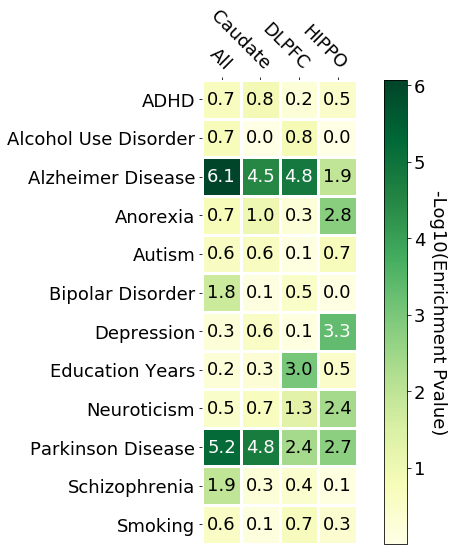

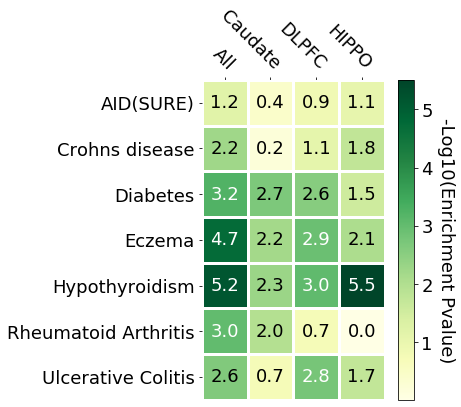

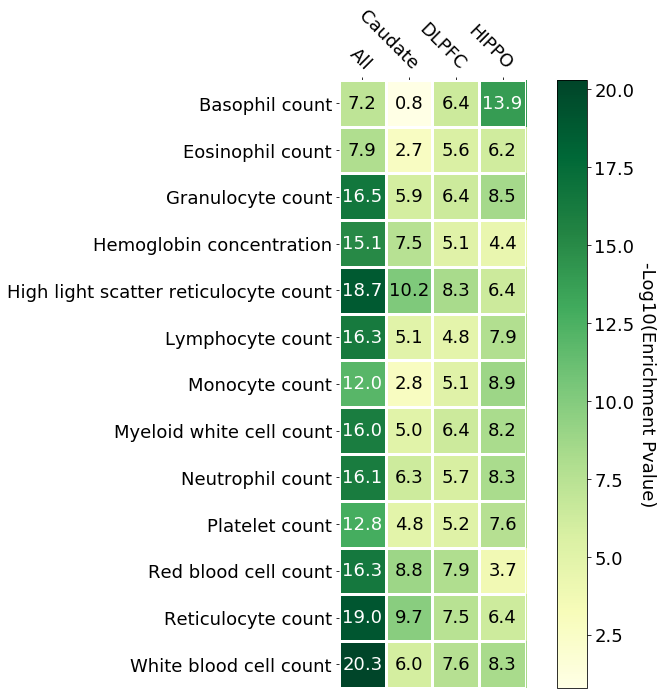

In [44]:
for group in df.Type.unique():
    figsize_dict = {'Blood': (10,10), 'Brain': (8,8), 'Immune': (7,6)}
    dfa = df[(df['Type'] == group)].copy().set_index('Trait')\
                                   .drop('Type', axis=1)\
                                   .rename(columns={'Hippo': 'HIPPO'})
    plot_heatmap(dfa, group, size=figsize_dict[group], direction='ALL')

### Upregulated DEGs

In [46]:
df_all = pd.DataFrame()
for sheet in ['%s_up' % x for x in sheet_names]:
    dfx = pd.read_excel("../_h/h2_summary.xlsx", sheet_name=sheet)\
            .loc[:, ['Trait', 'Type', 'Enrichment_p']]
    dfx['-Log10_p'] = -np.log(dfx.Enrichment_p)
    dfx['Tissue'] = sheet.replace('_up', '')
    df_all = pd.concat([df_all, dfx], axis=0)

df = df_all.pivot_table(index=['Trait', 'Type'], 
                        columns='Tissue', 
                        values='-Log10_p').reset_index()
df.head()

Tissue,Trait,Type,All,Caudate,DLPFC,Hippo
0,ADHD,Brain,1.116755,1.148000,0.834950,0.949434
1,AID(SURE),Immune,0.412040,1.571753,1.789063,1.001310
2,Alcohol Use Disorder,Brain,0.361306,0.215193,0.264535,0.779086
3,Alzheimer Disease,Brain,3.690114,2.067012,4.256109,1.678151
4,Anorexia,Brain,1.084419,0.418488,1.204538,0.097824


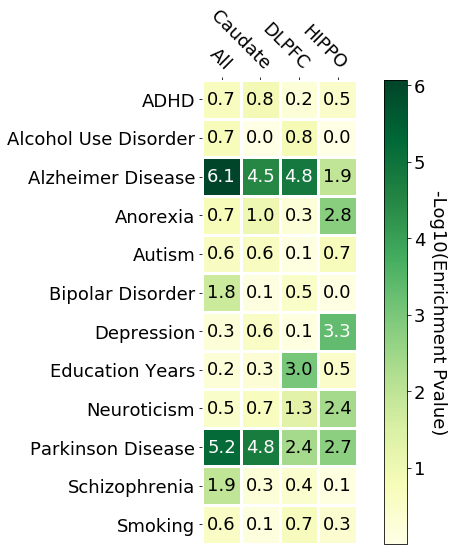

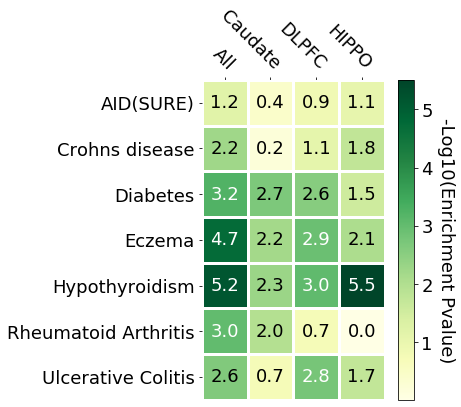

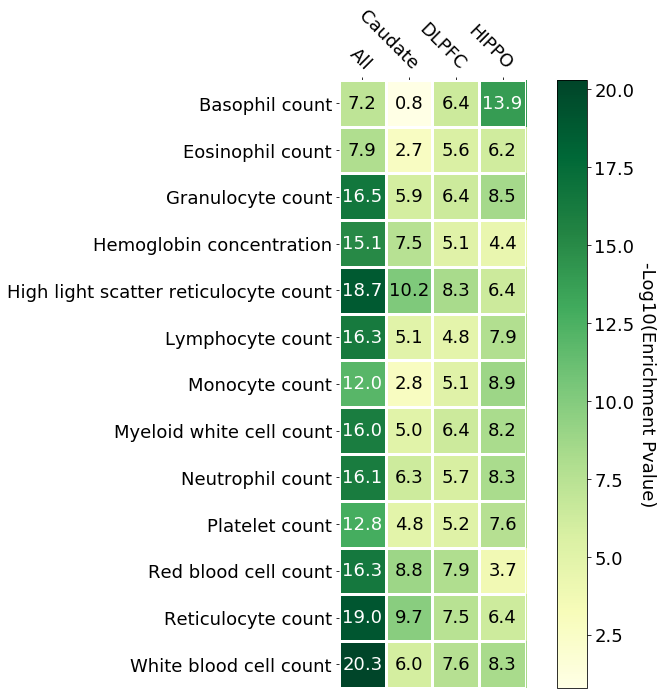

In [44]:
for group in df.Type.unique():
    figsize_dict = {'Blood': (10,10), 'Brain': (8,8), 'Immune': (7,6)}
    dfa = df[(df['Type'] == group)].copy().set_index('Trait')\
                                   .drop('Type', axis=1)\
                                   .rename(columns={'Hippo': 'HIPPO'})
    plot_heatmap(dfa, group, size=figsize_dict[group], direction='UP')

### Downregulated DEGs

In [47]:
df_all = pd.DataFrame()
for sheet in ['%s_down' % x for x in sheet_names]:
    dfx = pd.read_excel("../_h/h2_summary.xlsx", sheet_name=sheet)\
            .loc[:, ['Trait', 'Type', 'Enrichment_p']]
    dfx['-Log10_p'] = -np.log(dfx.Enrichment_p)
    dfx['Tissue'] = sheet.replace('_down', '')
    df_all = pd.concat([df_all, dfx], axis=0)

df = df_all.pivot_table(index=['Trait', 'Type'], 
                        columns='Tissue', 
                        values='-Log10_p').reset_index()
df.head()

Tissue,Trait,Type,All,Caudate,DLPFC,Hippo
0,ADHD,Brain,0.121165,0.013938,0.260259,0.194839
1,AID(SURE),Immune,0.860061,0.505904,0.531152,0.076541
2,Alcohol Use Disorder,Brain,0.425017,0.055485,0.714060,0.633421
3,Alzheimer Disease,Brain,1.973590,4.339534,1.737592,1.011661
4,Anorexia,Brain,3.529756,2.609064,1.157567,3.870932


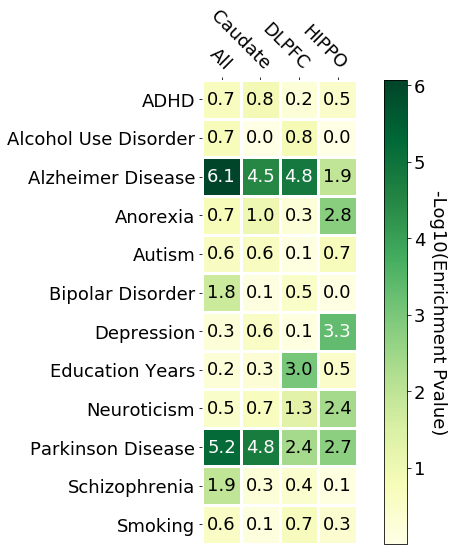

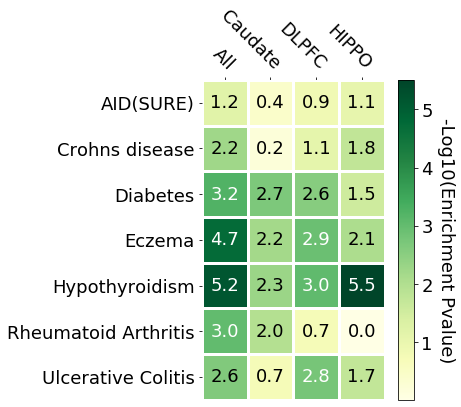

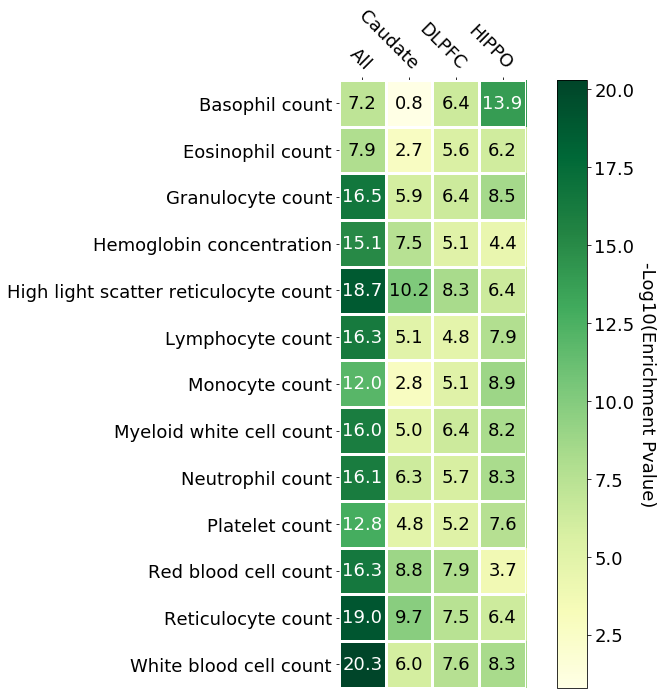

In [44]:
for group in df.Type.unique():
    figsize_dict = {'Blood': (10,10), 'Brain': (8,8), 'Immune': (7,6)}
    dfa = df[(df['Type'] == group)].copy().set_index('Trait')\
                                   .drop('Type', axis=1)\
                                   .rename(columns={'Hippo': 'HIPPO'})
    plot_heatmap(dfa, group, size=figsize_dict[group], direction='DOWN')